 # Collaboration and Competition

 ---

 In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

 ### 1. Start the Environment

 We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import numpy as np
import torch
from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

The environment is already saved in the Udacity Workspace and can be accessed at the file path provided below.

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Alternatively if running on your local computer you can use a local environment as follows:

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

 - **Mac**: `"path/to/Tennis.app"`
 - **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
 - **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
 - **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
 - **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
 - **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
 - **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

 For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
 ```
 env = UnityEnvironment(file_name="Tennis.app")
 ```

In [4]:
#env = UnityEnvironment(file_name="Tennis.app")

 Next, we will start the environment!
 
 Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

 ### 2. Examine the State and Action Spaces

 In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

 The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

 Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


 ### 3. Train the agent


In [7]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 6e-2              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
EPSILON_START = 7.0     # Starting value of noise scaling parameter
EPSILON_END = 0.01      # Minimum allowed value of noise scaling parameter
EPSILON_DECAY = 0.997   # Decay rate of noise scaling parameter
ADD_NOISE = True        # Whether to add noise to the learning


In [8]:
agent_0 = Agent(state_size, action_size, agent_number=0, gamma=GAMMA, tau=TAU,
    epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY,
    weight_decay=WEIGHT_DECAY, replay_buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,
    lr_actor=LR_ACTOR, lr_critic=LR_CRITIC)
agent_1 = Agent(state_size, action_size, agent_number=1, gamma=GAMMA, tau=TAU,
    epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY,
    weight_decay=WEIGHT_DECAY, replay_buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,
    lr_actor=LR_ACTOR, lr_critic=LR_CRITIC)

In [9]:
def act(states, add_noise=True):
    # Select an action for each agent
    action_0 = agent_0.act(states, add_noise)
    action_1 = agent_1.act(states, add_noise)
    
    # Combine actions
    actions = np.concatenate((action_0, action_1), axis=0)
    actions = np.reshape(actions, (1, action_size*num_agents))
    return actions

In [10]:
def step(states, actions, rewards, next_states, done):
    # Learning step
    agent_0.step(states, actions, rewards[0], next_states, done)
    agent_1.step(states, actions, rewards[1], next_states, done)

In [11]:
def train(n_episodes=1000, solve_score=0.5):
    print ("*** STARTED TRAINING ***")
    all_scores = []
    rolling_average_scores = []
    scores_window = deque(maxlen=100)

    for i_episode in range(n_episodes):
        #print("i_episode = {}".format(i_episode))
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = env_info.vector_observations
        states = np.reshape(states, (1, state_size*num_agents))
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)

        i_step = 0
        while True:
            actions = act(states, ADD_NOISE)                                          # Calculate agent actions
            env_info = env.step(actions)[brain_name]                                  # Send both agents' actions to the environment
            next_states = env_info.vector_observations                                # Get next states
            next_states = np.reshape(next_states, (1, state_size*num_agents))         # Combine the agent states into one state space
            rewards = env_info.rewards                                                # Get rewards
            done = env_info.local_done                                                # Get completion status of episode
            step(states, actions, rewards, next_states, done)                         # Learning steps for each agent

            scores += rewards                                                         # Update the agent scores
            states = next_states                                                      # Roll the state forward
            i_step += 1
            if np.any(done):                                                          # Exit if episode completed
                break

        #print('Episode completed in {} steps'.format(i_step+1))
        # Update agent noise scaling
        agent_0.update_noise_scaling()
        agent_1.update_noise_scaling()
        
        # Update scores
        scores_window.append(np.max(scores))
        all_scores.append(np.max(scores))
        rolling_average_scores.append(np.mean(scores_window))

        if i_episode % 10 == 0:
            print('Episode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(i_episode, np.max(scores), np.mean(scores_window)))

        if np.mean(scores_window) >= solve_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            print ("*** FINISHED TRAINING ***")
            break

    return all_scores, rolling_average_scores

In [12]:
all_scores, rolling_average_scores = train(solve_score=0.5);


*** STARTED TRAINING ***
Episode 0	Max Reward: 0.000	Average Reward: 0.000
Episode 10	Max Reward: 0.000	Average Reward: 0.016
Episode 20	Max Reward: 0.000	Average Reward: 0.013
Episode 30	Max Reward: 0.000	Average Reward: 0.009
Episode 40	Max Reward: 0.000	Average Reward: 0.009
Episode 50	Max Reward: 0.000	Average Reward: 0.007
Episode 60	Max Reward: 0.000	Average Reward: 0.011
Episode 70	Max Reward: 0.000	Average Reward: 0.012
Episode 80	Max Reward: 0.100	Average Reward: 0.012
Episode 90	Max Reward: 0.000	Average Reward: 0.011
Episode 100	Max Reward: 0.090	Average Reward: 0.012
Episode 110	Max Reward: 0.000	Average Reward: 0.015
Episode 120	Max Reward: 0.000	Average Reward: 0.016
Episode 130	Max Reward: 0.000	Average Reward: 0.017
Episode 140	Max Reward: 0.000	Average Reward: 0.020
Episode 150	Max Reward: 0.000	Average Reward: 0.021
Episode 160	Max Reward: 0.000	Average Reward: 0.020
Episode 170	Max Reward: 0.000	Average Reward: 0.019
Episode 180	Max Reward: 0.000	Average Reward: 0.01

 ### 4. Plot training episode scores


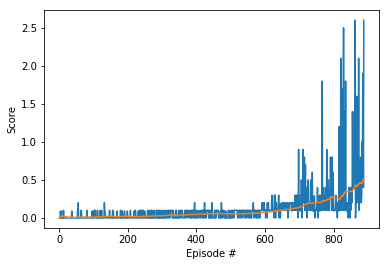

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores)
plt.plot(np.arange(1, len(rolling_average_scores)+1), rolling_average_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


 ### 5. Watch trained agents play tennis


In [14]:
def play (num_episodes=1000):
    # Set environment to evalulation mode
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    states = np.reshape(states, (1, state_size * num_agents))

    for i in range(num_episodes):
        actions = act(states, add_noise=False)             # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = np.reshape(env_info.vector_observations, (1, state_size * num_agents))        # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break



In [ ]:
# Load the trained neural network parameters
agent_0.actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth'))
agent_0.critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))
agent_1.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent_1.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

# Play tennis!
play()


 When finished, you can close the environment.

In [ ]:
env.close()
